# Decoding memory load from the ERP

In this notebook, we train a sliding classifier to decode the memory load from the 60-channel EEG data. 

2022 -- Felix Klotzsche 

In [23]:
# %% load libs:
from collections import defaultdict
from os import path as op
import sys
import json
import numpy as np

import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from scipy import stats

import mne
# from mne.epochs import concatenate_epochs
from mne.decoding import (SlidingEstimator, GeneralizingEstimator,
                          cross_val_multiscore, LinearModel, get_coef)

from library import config, helpers

Study path is set to: /raven/ptmp/fklotzsche/Experiments/vMemEcc


In [24]:
%load_ext autoreload
%autoreload 2

In [25]:
# %% Functions:

def get_epos(subID, epo_part, signaltype, condition, event_dict, picks_str):
    if signaltype == 'uncollapsed':
        fname = op.join(config.paths['03_preproc-rejectET'],
                        epo_part,
                        'cleaneddata',
                        f"{subID}-{epo_part}-rejepo-epo.fif")
    elif signaltype in ['collapsed', 'difference']:
        fname = op.join(config.paths['03_preproc-pooled'],
                        epo_part,
                        signaltype,
                        f"{subID}-{epo_part}-{signaltype}-epo.fif")
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)

    # pick channel selection:
    if (picks_str is not None) and (picks_str != 'All'):
        roi_dict = mne.channels.make_1020_channel_selections(epos.info)
        picks = [epos.ch_names[idx] for idx in roi_dict[picks_str]]
        epos.pick_channels(picks, ordered=True)

    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)


def avg_time(data, step=25, times=None):
    orig_shape = data.shape
    n_fill = step - (orig_shape[-1] % step)
    fill_shape = np.asarray(orig_shape)
    fill_shape[-1] = n_fill
    fill = np.ones(fill_shape) * np.nan
    data_f = np.concatenate([data, fill], axis=-1)
    data_res = np.nanmean(data_f.reshape(*orig_shape[:2], -1, step), axis=-1)

    if times is not None:
        f_times = np.r_[times, [np.nan] * n_fill]
        n_times = np.nanmean(f_times.reshape(-1, step), axis=-1)
        return data_res, n_times
    else:
        return data_res


def batch_trials(epos, batch_size):
    n_trials = len(epos)
    n_batches = int(n_trials / batch_size)
    rnd_seq = np.arange(n_trials)
    np.random.shuffle(rnd_seq)
    rnd_seq = rnd_seq[:n_batches * batch_size]
    rnd_seq = rnd_seq.reshape(-1, batch_size)
    batches = [epos[b].average() for b in rnd_seq]
    return(batches)


def get_data(subID, epo_part, signaltype, conditions, event_dict,
             batch_size=1, smooth_winsize=1, picks_str=None):
    epos_dict = defaultdict(dict)
    for cond in conditions:
        epos_dict[cond] = get_epos(subID,
                                   epo_part=epo_part,
                                   signaltype=signaltype,
                                   condition=cond,
                                   event_dict=event_dict,
                                   picks_str=picks_str)

    times = epos_dict[conditions[0]][0].copy().times
    info = epos_dict[conditions[0]][0].info

    # Setup data:
    if batch_size > 1:
        batches = defaultdict(list)
        for cond in conditions:
            batches[cond] = batch_trials(epos_dict[cond], batch_size)
            batches[cond] = np.asarray([b.data for b in batches[cond]])

        X = np.concatenate([batches[cond].data for cond in conditions], axis=0)
        n_ = {cond: batches[cond].shape[0] for cond in conditions}

    else:
        X = mne.concatenate_epochs([epos_dict[cond] for cond in conditions])
        X = X.get_data()
        n_ = {cond: len(epos_dict[cond]) for cond in conditions}

    if smooth_winsize > 1:
        X, times_n = avg_time(X, smooth_winsize, times=times)
    else:
        times_n = times

    y = np.r_[np.zeros(n_[conditions[0]]),
              np.concatenate([(np.ones(n_[conditions[i]]) * i)
                              for i in np.arange(1, len(conditions))])]

    return X, y, times_n, info


def decode(sub_list_str,
           conditions,
           epo_part='stimon',
           signaltype='collapsed',
           scoring='roc_auc',
           event_dict=config.event_dict,
           n_rep_sub=100,
           picks_str=None,
           shuffle_labels=False,
           batch_size=10,
           smooth_winsize=5,
           n_cv_folds=5,
           temp_gen=False,
           save_single_rep_scores=False,
           save_scores=True,
           save_patterns=False):

    contrast_str = '_vs_'.join(conditions)
    scoring = scoring  # 'roc_auc' # 'accuracy'
    cv_folds = n_cv_folds

    subs_processed = list()
    sub_scores = list()
    sub_scores_per_rep = list()
    sub_coef = list()
    times_n = list()

    for subID in sub_list_str:
        print(f'### RUNING SUBJECT {subID}')
        subs_processed.append(subID)
        all_scores = list()
        all_coef = list()
        for i in np.arange(n_rep_sub):
            X, y, times_n, info = get_data(subID,
                                           epo_part=epo_part,
                                           signaltype=signaltype,
                                           conditions=conditions,
                                           event_dict=event_dict,
                                           batch_size=batch_size,
                                           smooth_winsize=smooth_winsize,
                                           picks_str=picks_str)

            clf = make_pipeline(mne.decoding.Scaler(info),
                                mne.decoding.Vectorizer(),
                                LinearModel(
                                    LogisticRegression(solver='liblinear',
                                                       random_state=42,
                                                       verbose=False)))

            # TODO: refactor: rename "se"
            if temp_gen:
                gen_str = 'gen_temp'
                se = GeneralizingEstimator(clf,
                                           scoring=scoring,
                                           n_jobs=-2,
                                           verbose=0)
            else:
                gen_str = ''
                se = SlidingEstimator(clf,
                                      scoring=scoring,
                                      n_jobs=-2,
                                      verbose=0)

            if shuffle_labels:
                np.random.shuffle(y)
            for i in np.unique(y):
                print(f'Size of class {i}: {np.sum(y == i)}\n')
            scores = cross_val_multiscore(se, X=X, y=y, cv=cv_folds, verbose=0)
            scores = np.mean(scores, axis=0)
            all_scores.append(scores)
            se.fit(X, y)
            coef = get_coef(se, 'patterns_', inverse_transform=True)
            all_coef.append(coef)

        sub_scores = np.asarray(all_scores).mean(axis=0)
        sub_coef = np.asarray(all_coef).mean(axis=0)

        # save shizzle:
        shuf_labs = 'labels_shuffled' if shuffle_labels else ''

        if picks_str is not None:
            picks_str_folder = picks_str
        else:
            picks_str_folder = ''

        path_save = op.join(config.paths['06_decoding-sensorspace'], epo_part,
                            signaltype, contrast_str, gen_str,
                            scoring, picks_str_folder, shuf_labs)

        # save accuracies:
        if save_scores:
            fpath = op.join(path_save, 'scores')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, f'{subID}-scores_per_sub.npy')
            np.save(fname, sub_scores)
            np.save(fname[:-4] + '__times' + '.npy', times_n)
            del(fpath, fname)

        # save patterns:
        if save_patterns:
            sub_patterns = sub_coef
            fpath = op.join(path_save, 'patterns')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath, f'{subID}-patterns_per_sub.npy')
            np.save(fname, sub_patterns)
            np.save(fname[:-4] + '__times' + '.npy', times_n)
            del(fpath, fname)

        # save info:
        if save_scores or save_patterns or save_single_rep_scores:
            info_dict = {'included subs': subs_processed,
                         'n_rep_sub': n_rep_sub,
                         'batch_size': batch_size,
                         'smooth_winsize': smooth_winsize,
                         'cv_folds': cv_folds,
                         'scoring': scoring}
            fpath = path_save
            fname = op.join(fpath, f'{subID}-info.json')
            with open(fname, 'w+') as outfile:
                json.dump(info_dict, outfile)

        # save data from single reps:
        if save_single_rep_scores:
            if len(sub_scores_per_rep) == 0:
                sub_scores_per_rep = np.asarray(all_scores)
            else:
                sub_scores_per_rep = np.concatenate([sub_scores_per_rep,
                                                    np.asarray(all_scores)],
                                                    axis=0)

            fpath = op.join(path_save, 'single_rep_data')
            helpers.chkmk_dir(fpath)
            fname = op.join(fpath,
                            f'{subID}-'
                            f'reps{n_rep_sub}_'
                            f'swin{smooth_winsize}_batchs{batch_size}.npy')
            np.save(fname, sub_scores_per_rep)
            np.save(fname[:-4] + '__times' + '.npy', times_n)
            del(fpath, fname)

    return sub_scores, sub_coef, times_n


In [26]:
# %% setup params:

mne.set_log_level('WARNING')

# plotting:
plt_dict = defaultdict(dict)
pp = {'t_stimon':  0,
      'xmin': -0.2,
      'xmax': 2.3}
plt_dict['stimon'] = pp

# Set up parameters:
batch_size = 10
smooth_winsize = 10
n_rep_sub = 1
n_cv_folds = 5


In [ ]:

# Extract params:
helpers.extract_var("decod_sensorspace_batch_size", batch_size, exp_format=".0f")
helpers.extract_var("decod_sensorspace_smooth_winsize", smooth_winsize, exp_format=".0f")
helpers.extract_var("decod_sensorspace_cv_folds", n_cv_folds, exp_format=".0f")
helpers.extract_var("decod_sensorspace_n_rep_sub", n_rep_sub, exp_format=".0f")
if ((100 * 1 / n_cv_folds) % 1) > 0.0:
      exp_f_perc = ".2f"
else:
      exp_f_perc = ".0f"
helpers.extract_var("decod_sensorspace_cv_folds_train_perc", 100 * (n_cv_folds - 1) / n_cv_folds,
                    exp_format=exp_f_perc)
helpers.extract_var("decod_sensorspace_cv_folds_test_perc", 100 * 1 / n_cv_folds,
                    exp_format=exp_f_perc)



In [27]:


# structuring data:
sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

# when running on the cluster we want parallelization along the subject dimension
if not helpers.is_interactive(): 
    helpers.print_msg('Running Job Nr. ' + sys.argv[1])
    job_nr = int(float(sys.argv[1]))
    sub_list_str = [sub_list_str[job_nr]]   

event_dict = config.event_dict
cond_dict = {'Load': ['LoadLow', 'LoadHigh'],
             'Ecc': ['EccS', 'EccM', 'EccL']}



# %% Decode load across all eccentricities:

decod_results_load = defaultdict(dict)


# for shuf_labs in [False, True]:
#     for picks_str in ['All']: # ['Right', 'Left']: 
#         conditions = ['LoadLow', 'LoadHigh']
#         contrast_str = '_vs_'.join(conditions)
#         sc_, pat_, ts_ = decode(sub_list_str, 
#                                 conditions=conditions,
#                                 epo_part='stimon', 
#                                 signaltype='collapsed',
#                                 event_dict=config.event_dict, 
#                                 n_rep_sub=n_rep_sub,
#                                 picks_str=picks_str,
#                                 shuffle_labels=shuf_labs,
#                                 batch_size=batch_size,
#                                 n_cv_folds=n_cv_folds,
#                                 temp_gen=False,
#                                 smooth_winsize=smooth_winsize,
#                                 save_single_rep_scores=True,
#                                 save_patterns=True,
#                                 save_scores=True)

In [ ]:
# %% decode load per eccentricity:

decod_results_load = defaultdict(dict)

for ecc in ['EccL']:  # cond_dict['Ecc']:
    conditions = ['LoadLow' + ecc, 'LoadHigh' + ecc]
    contrast_str = '_vs_'.join(conditions)
    for shuf_labs in [False]: #   , True]:
        sc_, pat_, ts_ = decode(sub_list_str,
                                conditions=conditions,
                                epo_part='stimon',
                                signaltype='collapsed',
                                scoring='roc_auc',
                                event_dict=config.event_dict,
                                n_rep_sub=n_rep_sub,
                                picks_str='All',
                                shuffle_labels=shuf_labs,
                                batch_size=batch_size,
                                n_cv_folds=n_cv_folds,
                                smooth_winsize=smooth_winsize,
                                temp_gen=False,
                                save_single_rep_scores=False,
                                save_patterns=False,
                                save_scores=False)


## Decoding the eccentricity
As a control analysis, we decode the eccentricity level. 

In [38]:
conditions = ['EccS', 'EccM', 'EccL']

sc, ps, ti = decode(sub_list_str,
                    conditions=conditions,
                    epo_part='stimon',
                    signaltype='collapsed',
                    scoring='roc_auc_ovo',
                    event_dict=config.event_dict,
                    n_rep_sub=1,
                    picks_str='All',
                    shuffle_labels=False,
                    batch_size=batch_size,
                    n_cv_folds=n_cv_folds,
                    smooth_winsize=smooth_winsize,
                    temp_gen=False,
                    save_single_rep_scores=False,
                    save_patterns=False,
                    save_scores=False)

### RUNING SUBJECT VME_S01
Size of class 0.0: 21

Size of class 1.0: 23

Size of class 2.0: 23



  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

### RUNING SUBJECT VME_S02
Size of class 0.0: 20

Size of class 1.0: 19

Size of class 2.0: 21



  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/146 [00:00<?,       ?it/s]

KeyboardInterrupt: 

In [37]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

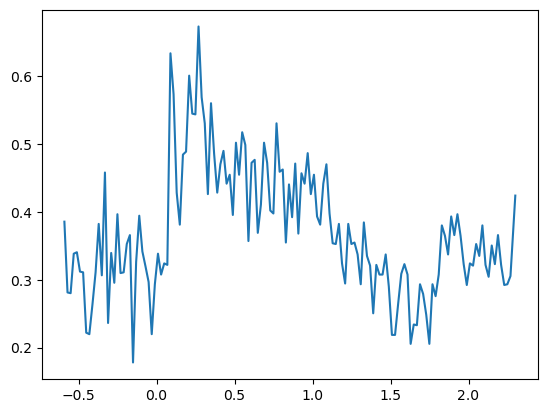

In [40]:
plt.plot(ti, sc)